- Lakukan cleaning dan preprocessing terhadap data yang akan dipakai
- Buat sebuah classification model dengan menggunakan Logistic Regression dengan stroke prediction sebagai target

[dataset](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset)

# 2 - Import Libraries

In [1334]:
# Import Library
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split

from scipy.stats import kendalltau
import scipy.stats as stats
from sklearn.feature_selection import f_classif

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

import joblib, json

# 3 - Data Loading

- [ ] drop column `id`

In [1335]:
# Load dataset
data = pd.read_csv("./healthcare-dataset-stroke-data.csv")
data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.00,0,1,Yes,Private,Urban,228.69,36.60,formerly smoked,1
1,51676,Female,61.00,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.00,0,1,Yes,Private,Rural,105.92,32.50,never smoked,1
3,60182,Female,49.00,0,0,Yes,Private,Urban,171.23,34.40,smokes,1
4,1665,Female,79.00,1,0,Yes,Self-employed,Rural,174.12,24.00,never smoked,1


## 3.1 - data.info()

- [x] handle null rows in column `bmi` with median imputation [outline](#41---column-bmi) and [done](#541---x_train)
- [x] handle null rows in column `avg_glucose_level` with median imputation [outline](#42---column-avg_glucose_level) and [done](#54---handling-missing-values)
- [x] change columns dtypes to category: `gender`, `hypertension`, `heart_disease`, `ever_married`, `work_type`, `Residence_type`, `smoking_status`

In [1336]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


- [x] check outliers; decision
  - [x] column `avg_glucose_level`; natural outliers [outline](#42---column-avg_glucose_level)
  - [x] column `bmi`; natural outliers [outline](#41---column-bmi)
- [x] check column `gender`; natural outliers [outline](#32-value_counts)

In [1337]:
pd.options.display.float_format = "{0:,.2f}".format
data.drop(['id', 'hypertension', 'heart_disease', 'stroke'], axis='columns').describe()

,age,avg_glucose_level,bmi
count,"5,110.00","5,110.00","4,909.00"
mean,43.23,106.15,28.89
std,22.61,45.28,7.85
min,0.08,55.12,10.30
25%,25.00,77.25,23.50
50%,45.00,91.88,28.10
75%,61.00,114.09,33.10
max,82.00,271.74,97.60


In [1338]:
data.drop(['id'], axis='columns').describe(include='object')

,gender,ever_married,work_type,Residence_type,smoking_status
count,5110,5110,5110,5110,5110
unique,3,2,5,2,4
top,Female,Yes,Private,Urban,never smoked
freq,2994,3353,2925,2596,1892


### 3.1.1 - change dtypes to category

`gender`, `hypertension`, `heart_disease`, `ever_married`, `work_type`, `Residence_type`, `smoking_status`

In [1339]:
columns = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status', 'stroke']

data[columns] = data[columns].astype('category')

del columns

## 3.2 value_counts

- `gender` is nominal
- `ever_married` is ordinal
- `work_type` is nominal
- `Residence_type` is nominal
- `smoking_status` is nominal

- column `gender` can have value as `Other`. 
  
  Some people refuse to reveal his/her gender. Although this is a natural outlier. If gender do have correlation with stroke, even 1% less accurate Model will mean that 3 people with stroke classified as `not stroke`.

In [1340]:
data['stroke'].value_counts()

0    4861
1     249
Name: stroke, dtype: int64

In [1341]:
data['work_type'].value_counts()

Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64

In [1342]:
data['smoking_status'].value_counts()

never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64

# 4 - Exploratory Data Analysis (EDA)

## 4.1 - column `bmi`

[BMI is body mass divided by squared body height.](https://www.cdc.gov/nccdphp/dnpao/growthcharts/training/bmiage/page5_1.html#:~:text=With%20the%20metric%20system%2C%20the,by%2010%2C000%2C%20can%20be%20used.)

BMI 100 kg/m^2 for a person with height of 1.75 meter will have a weight of 100 * 1.75^2 = 306.25 kg!

[There are people with weight over 300 kg](https://www.indiatimes.com/trending/wtf/world-s-heaviest-man-loses-300-kg-his-guinness-world-record-358037.html)

Therefore, natural outliers.

In [1343]:
# highly skewed to the right
data['bmi'].skew()

1.0553402052962912

<AxesSubplot: xlabel='bmi'>

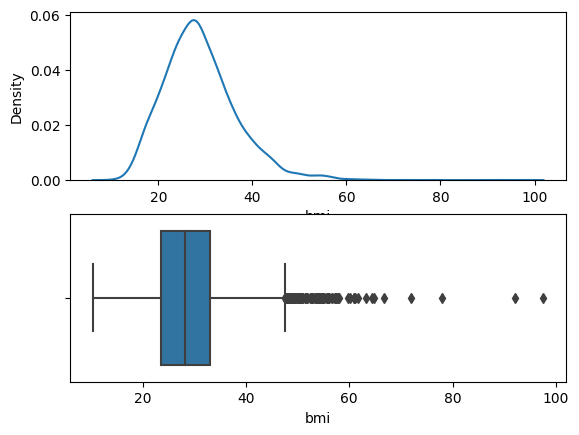

In [1344]:
# there are outliers
fig, axes = plt.subplots(nrows=2, ncols=1)
sns.kdeplot(data=data, x="bmi", ax=axes[0])
sns.boxplot(data=data, x="bmi", ax=axes[1])

## 4.2 - column `avg_glucose_level`

> [A blood sugar level of 200 mg/dL or higher indicates you have diabetes.](https://www.cdc.gov/diabetes/basics/getting-tested.html)

[There are people with blood sugar level above 2,500 mg/dL](https://www.guinnessworldrecords.com/world-records/highest-blood-sugar-level#:~:text=Michael%20Patrick%20Buonocore%20(USA)%20(,%2D120%20mg%2Fdl).)

Therefore, natural outliers.

In [1345]:
# highly skewed to the right
data['avg_glucose_level'].skew()

1.5722838665030459

<AxesSubplot: xlabel='avg_glucose_level'>

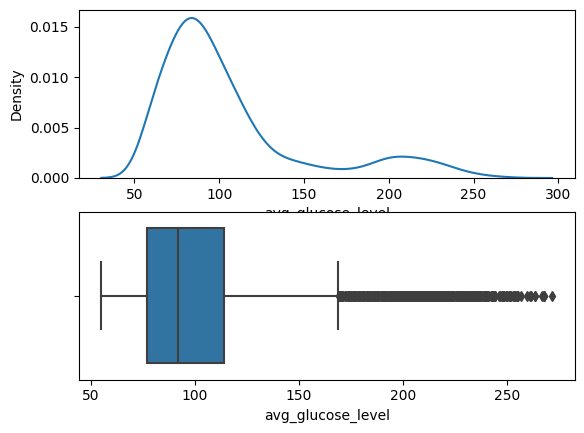

In [1346]:
# there are outliers
fig, axes = plt.subplots(nrows=2, ncols=1)
sns.kdeplot(data=data, x="avg_glucose_level", ax=axes[0])
sns.boxplot(data=data, x="avg_glucose_level", ax=axes[1])

## 4.3 - age, avg_glucose_level, bmi vs stroke

- age (>70 ish) tends to have stroke.
- avg_glucose_level (50 - 100 ish) tends to have stroke
- bmi (20 - 40 ish) tends to have stroke


<AxesSubplot: xlabel='bmi', ylabel='Count'>

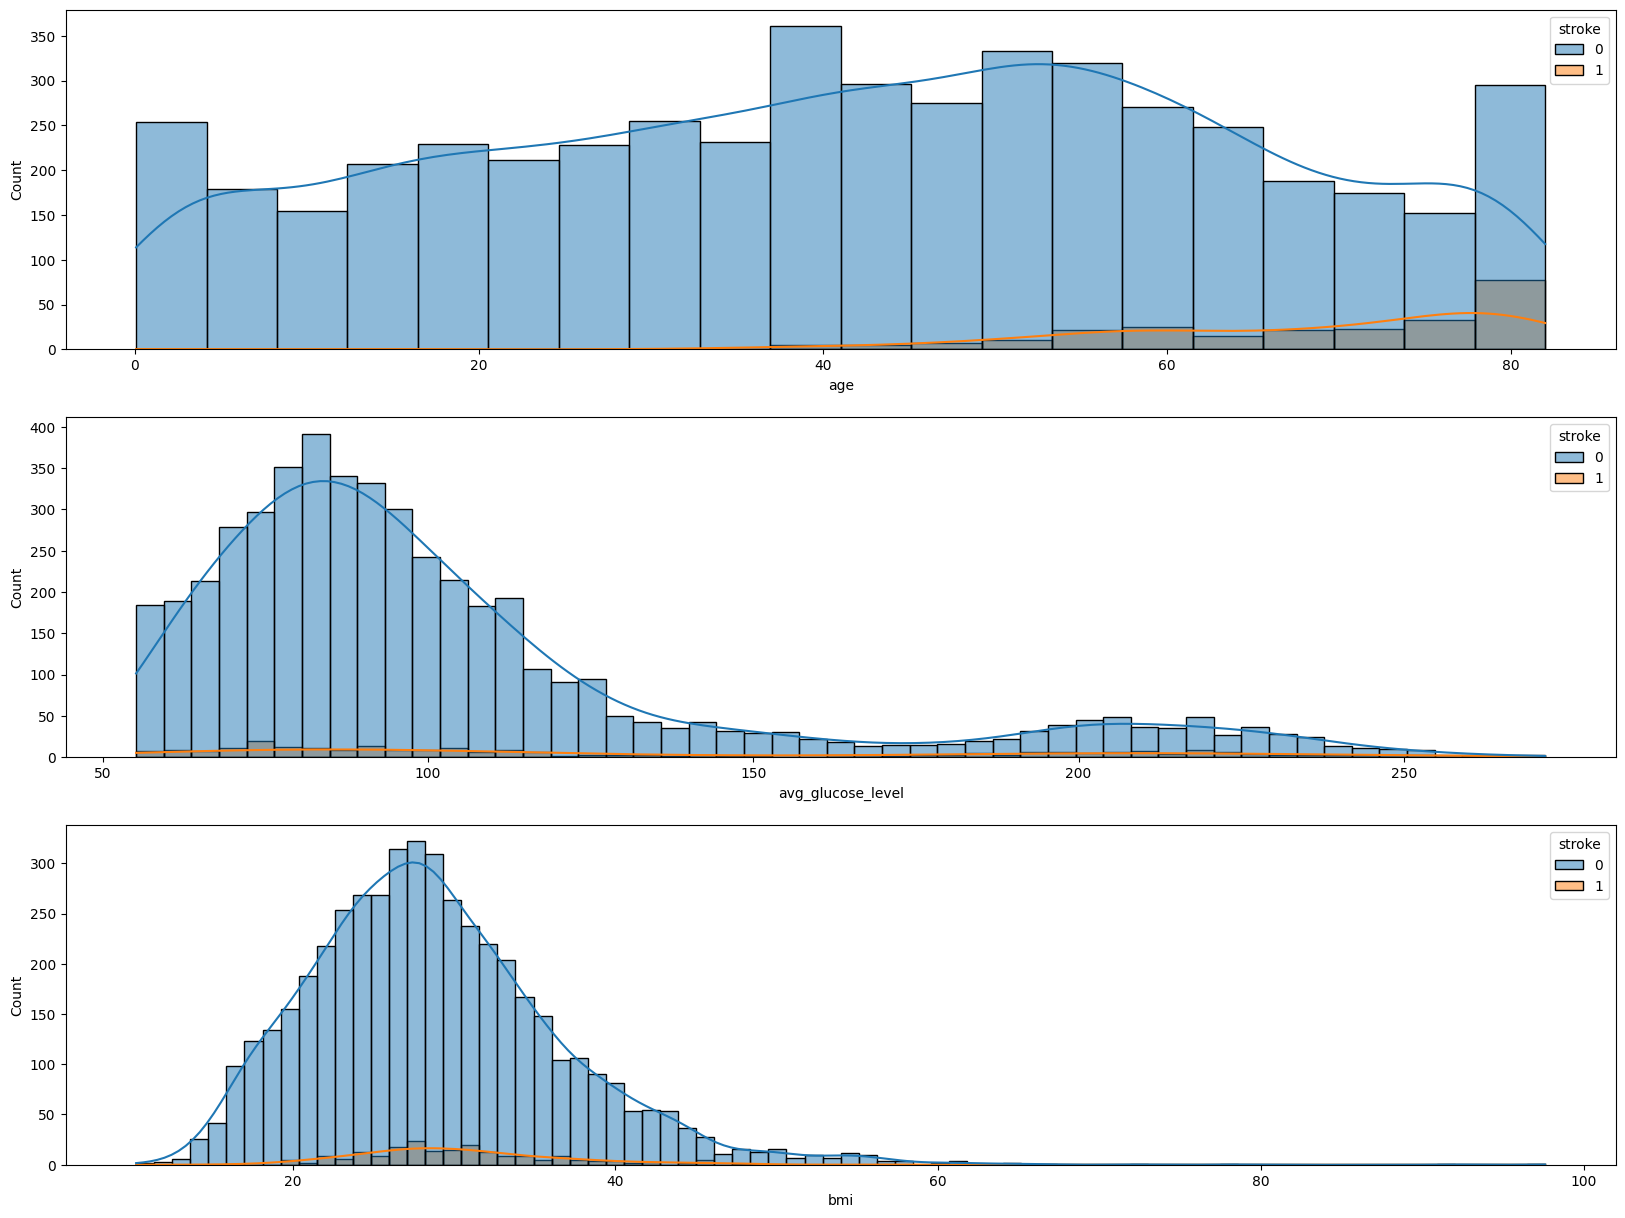

In [1347]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(20,15))
sns.histplot(data=data, x="age", hue="stroke", kde=True, ax=axes[0])
sns.histplot(data=data, x="avg_glucose_level",  hue="stroke", kde=True, ax=axes[1])
sns.histplot(data=data, x="bmi",  hue="stroke", kde=True, ax=axes[2])

<AxesSubplot: xlabel='bmi', ylabel='stroke'>

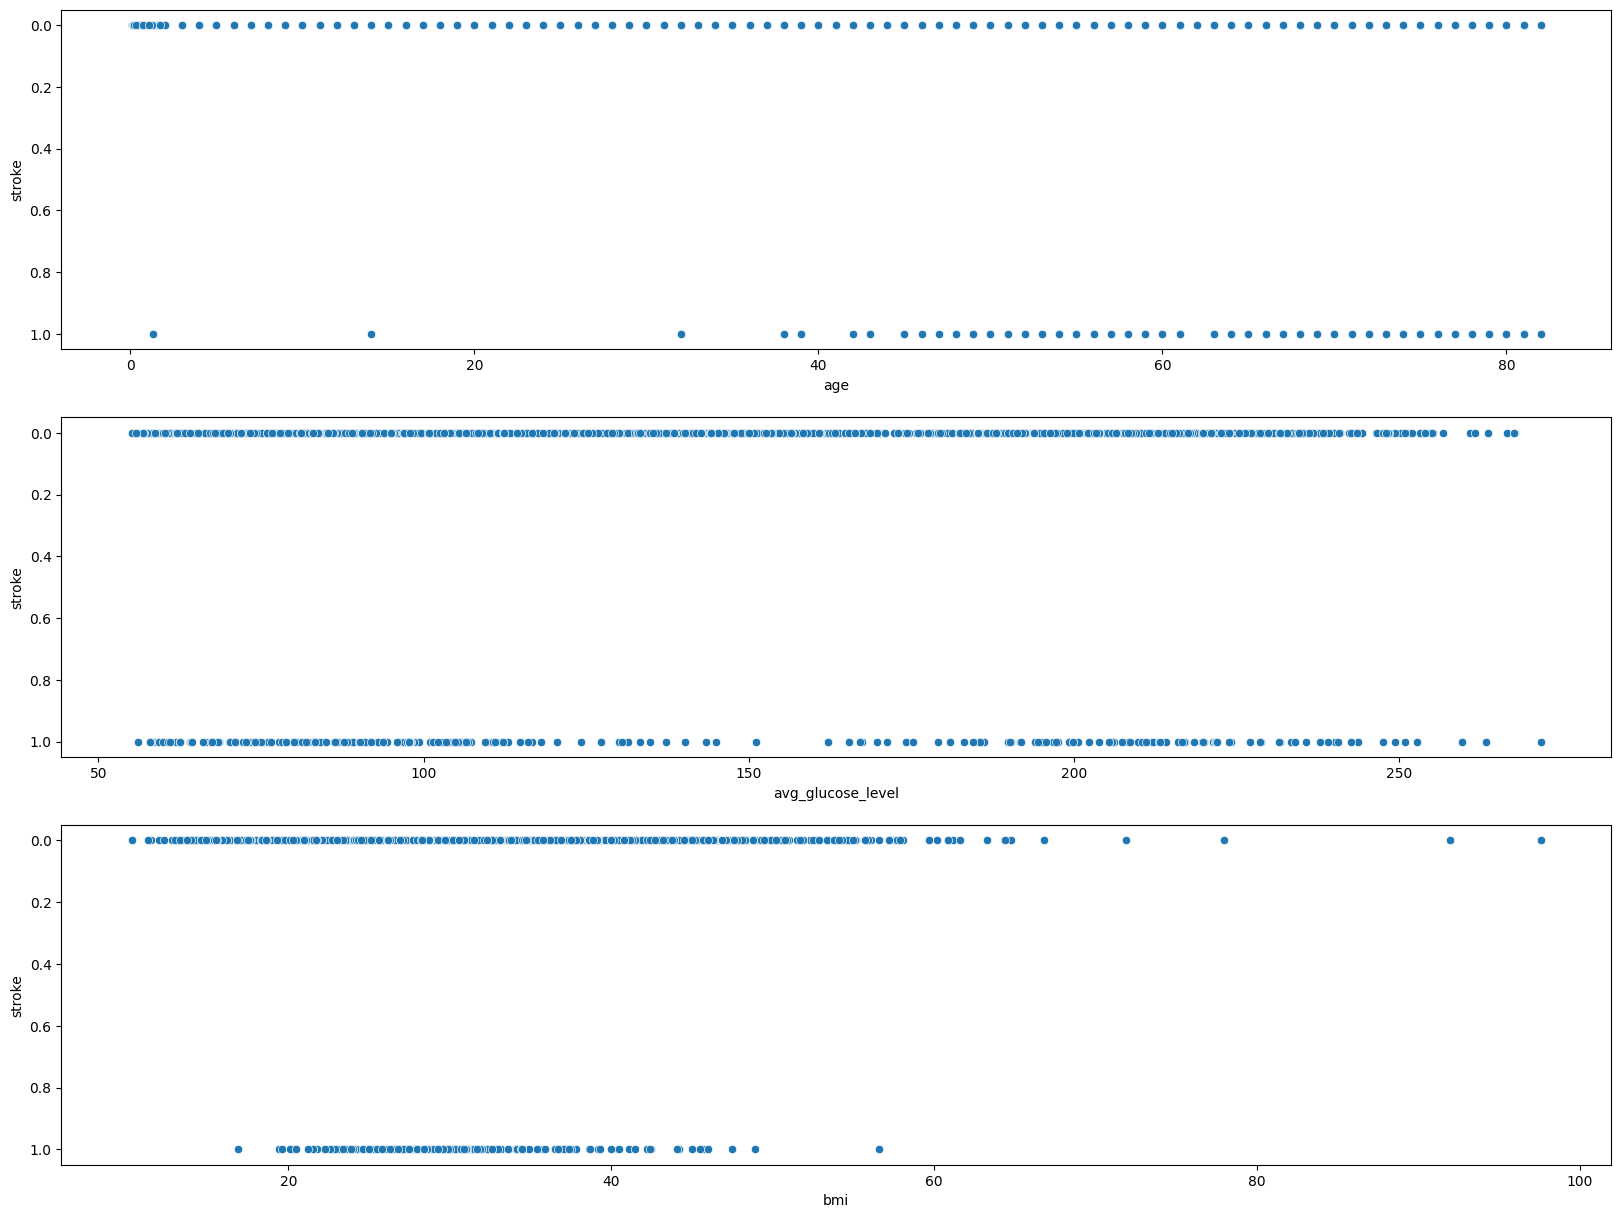

In [1348]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(20,15))
sns.scatterplot(data=data, x="age", y="stroke", ax=axes[0])
sns.scatterplot(data=data, x="avg_glucose_level",  y="stroke", ax=axes[1])
sns.scatterplot(data=data, x="bmi",  y="stroke", ax=axes[2])

## 4.4 - target

the dataset is imbalanced.

- [ ] do over sampling

In [1349]:
data['stroke'].value_counts()

0    4861
1     249
Name: stroke, dtype: int64

# 5 - Data Preprocessing

## 5.1 - Inference Set

In [1350]:
# Sampling data for Model Inference
# the dataset is imbalanced
data_inf = data.groupby("stroke").sample(5, random_state=42)
data_inf['stroke'].value_counts()

0    5
1    5
Name: stroke, dtype: int64

In [1351]:
# Remove Inference Set from dataset.
data_train_test = data.drop(data_inf.index)

In [1352]:
# Reset the index.
data_train_test.reset_index(drop=True, inplace=True)
data_inf.reset_index(drop=True, inplace=True)

## 5.2 - Splitting dataset to X and y

In [1353]:
# drop column target from X
X = data_train_test.drop(['stroke'], axis='columns')

# copy column target to y
y = data_train_test['stroke'].copy()

### 5.2.1 - Over sampling and Under sampling

The model trained with dataset by combining over sampling and under sampling is under performing compared to the model trained with over sampling.

In [1354]:
y.value_counts()

0    4856
1     244
Name: stroke, dtype: int64

In [1355]:
ros = RandomOverSampler(sampling_strategy=1)
X_res, y_res = ros.fit_resample(X, y)

In [1356]:
y_res.value_counts()

0    4856
1    4856
Name: stroke, dtype: int64

### 5.2.1 - Splitting dataset to Train Set and Test Set

In [1357]:
X_train, X_test, y_train, y_test = \
    train_test_split(X_res, y_res, test_size=0.2, random_state=42)

## 5.3 - Handling Outliers

there are natural outliers. [outline](#41---column-bmi) and [outline](#42---column-avg_glucose_level)

## 5.4 - Handling Missing Values

### 5.4.1 - X_train

In [1358]:
# Check missing values
X_train.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  714
smoking_status         0
dtype: int64

In [1359]:
# store bmi median for handling missing values in other set.
bmi_median = X_train['bmi'].median()

In [1360]:
# fill missing values
X_train['bmi'].fillna(value=bmi_median, inplace=True)

### 5.4.2 - X_test

In [1361]:
# Check missing values in X_test
X_test.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  207
smoking_status         0
dtype: int64

In [1362]:
# fill na with median
X_test['bmi'].fillna(value=bmi_median, inplace=True)

In [1363]:
# Check missing values in `y_train`
y_train.isnull().sum()

0

In [1364]:
# Check missing values in `y_test`
y_test.isnull().sum()

0

## 5.5 - Feature Selection

### 5.5.1 - drop columns with no correlation to target

column `id` is a unique identification number assigned to each person.

In [1365]:
X_train

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
6889,24669,Female,77.00,0,1,Yes,Private,Rural,231.56,36.90,never smoked
3469,52472,Male,14.00,0,0,No,children,Urban,74.54,25.20,Unknown
3533,18891,Male,24.00,0,0,No,Govt_job,Rural,99.65,50.30,never smoked
5786,51314,Female,78.00,0,0,Yes,Private,Urban,106.74,33.00,formerly smoked
7550,31720,Female,38.00,0,0,No,Self-employed,Urban,82.28,24.00,formerly smoked
...,...,...,...,...,...,...,...,...,...,...,...
5734,66159,Female,80.00,0,1,Yes,Self-employed,Rural,66.72,21.70,formerly smoked
5191,26727,Female,79.00,0,0,No,Private,Rural,88.92,22.90,never smoked
5390,35578,Male,78.00,0,0,No,Self-employed,Urban,90.19,26.90,never smoked
860,2314,Male,52.00,0,0,Yes,Private,Urban,226.70,28.50,smokes


In [1366]:
X_train.drop(['id'], axis=1, inplace=True)
X_test.drop(['id'], axis=1, inplace=True)

### 5.5.2 - feature selection with ANOVA

- column `age`, `avg_glucose_level`, `bmi` significantly affects the stroke outcome.
- [x] drop column `bmi`.

  column `bmi` have low f_statistic.

In [1368]:
features_candidate = ['age', 'avg_glucose_level', 'bmi']
f_statistic, pvalues = f_classif(X_train[features_candidate], y_train)

for index, feature in enumerate(features_candidate):
    print("column {0}; f_statistic {1:.2f}; pvalue {2:.2f} <= 5% = {3}"
          .format(feature, f_statistic[index], pvalues[index], pvalues[index] <= 0.05))

del index, feature, features_candidate, f_statistic, pvalues

column age; f_statistic 3936.77; pvalue 0.00 <= 5% = True
column avg_glucose_level; f_statistic 494.22; pvalue 0.00 <= 5% = True
column bmi; f_statistic 73.90; pvalue 0.00 <= 5% = True


In [1369]:
X_train.drop(['bmi'], axis=1, inplace=True)
X_test.drop(['bmi'], axis=1, inplace=True)

### 5.5.3 - feature selection with chi-squared

- column `stroke` is dependent with columns `hypertension`, `heart_disease`, `ever_married`, `work_type`.

In [1370]:
features_candidate = ['gender', 'hypertension', 'heart_disease', 'ever_married', 
                      'work_type', 'Residence_type', 'smoking_status']

for feature in features_candidate:
    contingency_table = pd.crosstab(X_train[feature], y_train)
    # display(contingency_table)

    chi2, pvalue, dof, expected = stats.chi2_contingency(observed=contingency_table)
    print("column {0}; pvalue = {1:.2f} <= 5%: {2}"
        .format(feature, pvalue, pvalue <= 0.05))

del features_candidate, feature

column gender; pvalue = 0.20 <= 5%: False
column hypertension; pvalue = 0.00 <= 5%: True
column heart_disease; pvalue = 0.00 <= 5%: True
column ever_married; pvalue = 0.00 <= 5%: True
column work_type; pvalue = 0.00 <= 5%: True
column Residence_type; pvalue = 0.00 <= 5%: True
column smoking_status; pvalue = 0.00 <= 5%: True


In [1371]:
X_train.drop(['gender'], axis=1, inplace=True)
X_test.drop(['gender'], axis=1, inplace=True)

### 5.5.4 - split dataset to numerical and categorical columns

In [1372]:
num_columns = ['age', 'avg_glucose_level']
ord_columns = ['hypertension', 'heart_disease', 'ever_married']
ohc_columns = ['work_type', 'Residence_type', 'smoking_status']

print('Numerical columns:', num_columns)
print('Ordinal columns:', ord_columns)
print('Nominal columns', ohc_columns)

Numerical columns: ['age', 'avg_glucose_level']
Ordinal columns: ['hypertension', 'heart_disease', 'ever_married']
Nominal columns ['work_type', 'Residence_type', 'smoking_status']


### 5.5.5 - split dataset to train set and test set

In [1373]:
X_train_num = X_train[num_columns]
X_test_num = X_test[num_columns]

X_train_ord = X_train[ord_columns]
X_test_ord = X_test[ord_columns]

X_train_ohc = X_train[ohc_columns]
X_test_ohc = X_test[ohc_columns]

## 5.6 - Feature Engineering

### 5.6.1 - Feature Scaling

In [1374]:
X_train_num

,age,avg_glucose_level
6889,77.00,231.56
3469,14.00,74.54
3533,24.00,99.65
5786,78.00,106.74
7550,38.00,82.28
...,...,...
5734,80.00,66.72
5191,79.00,88.92
5390,78.00,90.19
860,52.00,226.70


In [1375]:
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(X_train_num)

X_train_num_scaled = scaler.transform(X_train_num)
X_test_num_scaled = scaler.transform(X_test_num)

In [1376]:
X_test_num_scaled

array([[1.        , 0.13345951],
       [0.08447266, 0.06624504],
       [0.95117188, 0.01592651],
       ...,
       [0.09667969, 0.08166374],
       [0.95117188, 0.17546856],
       [0.609375  , 0.21715446]])

### 5.6.2 - Feature Encoding

#### 5.6.2.1 - Ordinal

In [1377]:
ord_enc = OrdinalEncoder(categories=[[0,1],
                                     [0,1],
                                     ['No', 'Yes']])
ord_enc.fit(X_train_ord)

X_train_ord_encoded = ord_enc.transform(X_train_ord)
X_test_ord_encoded = ord_enc.transform(X_test_ord)

#### 5.6.2.2 - Nominal

In [1378]:
ohc_enc = OneHotEncoder(drop="first", handle_unknown="ignore")
ohc_enc.fit(X_train_ohc)

X_train_ohc_encoded = ohc_enc.transform(X_train_ohc).toarray()
X_test_ohc_encoded = ohc_enc.transform(X_test_ohc).toarray()

## 5.7 - Concate numerical and categorical columns

In [1379]:
X_train_final = np.concatenate([X_train_num_scaled, 
                                X_train_ord_encoded, 
                                X_train_ohc_encoded], axis=1)
X_test_final = np.concatenate([X_test_num_scaled, 
                               X_test_ord_encoded, 
                               X_test_ohc_encoded], axis=1)

In [1380]:
X_train_final.shape

(7769, 13)

# 6 - Model Definition

## 6.1 - Logistic Regression

karena outputnya categorical

In [1381]:
clf = LogisticRegression(random_state=0)

## 6.2 - KNN

In [1382]:
knn = KNeighborsClassifier(n_neighbors=2)

## 6.3 - SVM

In [1383]:
parameters = {
    'C':[0.001, 0.01,0.1,1,10, 100, 1000], 
    'gamma':[0.001, 0.01,0.1,1,100, 1000]
}

svm = RandomizedSearchCV(SVC(probability= True), parameters, cv=5)

## 6.4 - Random Forest

In [1384]:
rf = RandomForestClassifier(n_estimators= 100)

## 6.5 - XGBoost

In [1385]:
xgb = XGBClassifier()

# 7 - Model Training

## 7.1 - Logistic Regression

In [1386]:
# Train the model
clf.fit(X=X_train_final, y=y_train)

LogisticRegression(random_state=0)

## 7.2 - KNN

In [1387]:
knn.fit(X_train_final, y_train)

KNeighborsClassifier(n_neighbors=2)

## 7.3 - SVM

In [1388]:
svm.fit(X_train_final, y_train)

RandomizedSearchCV(cv=5, estimator=SVC(probability=True),
                   param_distributions={'C': [0.001, 0.01, 0.1, 1, 10, 100,
                                              1000],
                                        'gamma': [0.001, 0.01, 0.1, 1, 100,
                                                  1000]})

## 7.4 - Random Forest

In [1389]:
rf.fit(X_train_final, y_train)

RandomForestClassifier()

## 7.5 - XGBoost

In [1390]:
xgb.fit(X_train_final, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)

# 8 - Model Evaluation

In [1391]:
def print_accuracy_score(y_true, y_pred):
    print('Accuracy Score', accuracy_score(y_true=y_true, y_pred=y_pred))

In [1392]:
def print_confusion_matrix(y_true, y_pred, model):
    cm = confusion_matrix(y_true=y_true, y_pred=y_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()
    plt.show()

    print(classification_report(y_true=y_true, y_pred=y_pred, zero_division=0))

In [1393]:
def save_model(folder_name, model):
    with open('model/{0}/v1/model.pkl'.format(folder_name), 'wb') as file_1:
        joblib.dump(model, file_1)

    with open('model/{0}/v1/scaler.pkl'.format(folder_name), 'wb') as file_2:
        joblib.dump(scaler, file_2)

    with open('model/{0}/v1/ord_enc.pkl'.format(folder_name), 'wb') as file_3:
        joblib.dump(ord_enc, file_3)

    with open('model/{0}/v1/ohc_enc.pkl'.format(folder_name), 'wb') as file_4:
        joblib.dump(ohc_enc, file_4)

    with open('model/{0}/v1/num_columns.txt'.format(folder_name), 'w') as file_5:
        json.dump(num_columns, file_5)

    with open('model/{0}/v1/ord_columns.txt'.format(folder_name), 'w') as file_6:
        json.dump(ord_columns, file_6)

    with open('model/{0}/v1/ohc_columns.txt'.format(folder_name), 'w') as file_7:
        json.dump(ohc_columns, file_7)

## 8.1 - Logistic Regression

The model can't detect stroke.

In [1394]:
y_train_pred_clf = clf.predict(X=X_train_final)
y_test_pred_clf = clf.predict(X=X_test_final)

In [1395]:
print_accuracy_score(y_train, y_train_pred_clf)
print_accuracy_score(y_test, y_test_pred_clf)

Accuracy Score 0.7784785686703566
Accuracy Score 0.7637673700463201


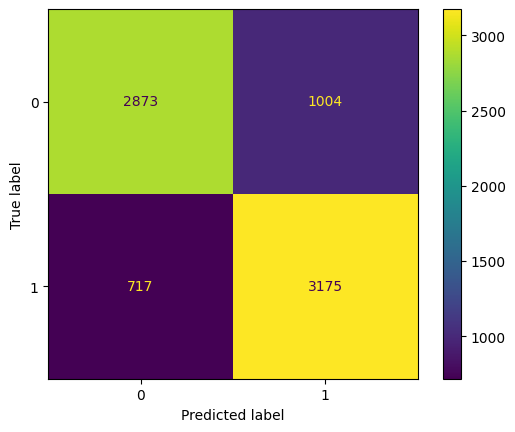

              precision    recall  f1-score   support

           0       0.80      0.74      0.77      3877
           1       0.76      0.82      0.79      3892

    accuracy                           0.78      7769
   macro avg       0.78      0.78      0.78      7769
weighted avg       0.78      0.78      0.78      7769



In [1396]:
print_confusion_matrix(y_train, y_train_pred_clf, clf)

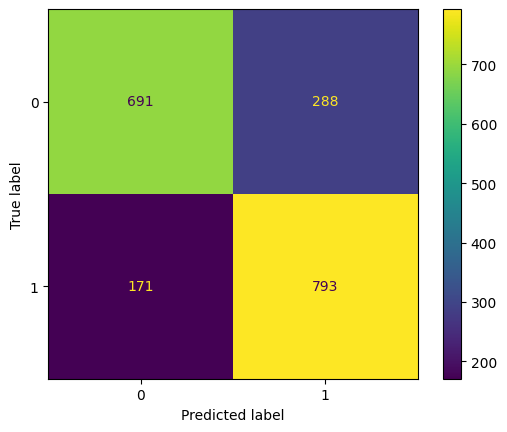

              precision    recall  f1-score   support

           0       0.80      0.71      0.75       979
           1       0.73      0.82      0.78       964

    accuracy                           0.76      1943
   macro avg       0.77      0.76      0.76      1943
weighted avg       0.77      0.76      0.76      1943



In [1397]:
print_confusion_matrix(y_test, y_test_pred_clf, clf)

## 8.2 - KNN

In [1398]:
y_train_pred_knn = knn.predict(X_train_final)
y_test_pred_knn = knn.predict(X_test_final)

In [1399]:
print_accuracy_score(y_train, y_train_pred_knn)
print_accuracy_score(y_test, y_test_pred_knn)

Accuracy Score 1.0
Accuracy Score 0.970663921770458


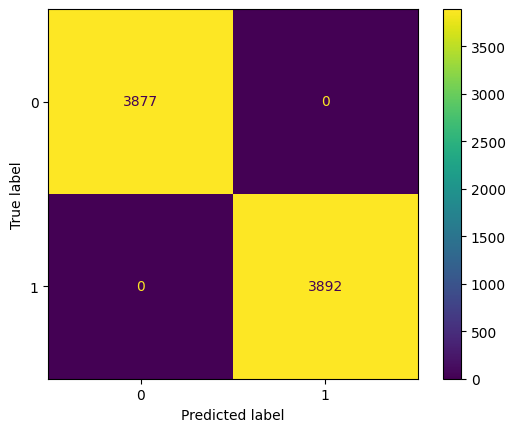

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3877
           1       1.00      1.00      1.00      3892

    accuracy                           1.00      7769
   macro avg       1.00      1.00      1.00      7769
weighted avg       1.00      1.00      1.00      7769



In [1400]:
print_confusion_matrix(y_train, y_train_pred_knn, knn)

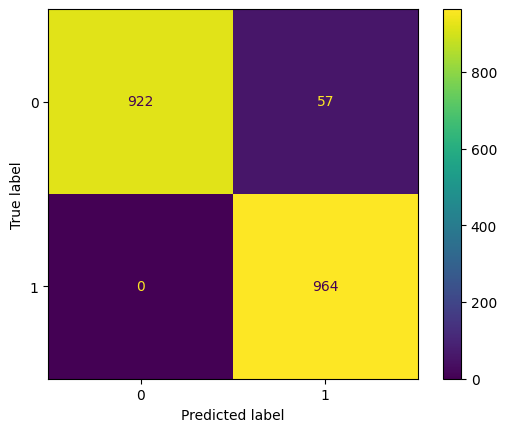

              precision    recall  f1-score   support

           0       1.00      0.94      0.97       979
           1       0.94      1.00      0.97       964

    accuracy                           0.97      1943
   macro avg       0.97      0.97      0.97      1943
weighted avg       0.97      0.97      0.97      1943



In [1401]:
print_confusion_matrix(y_test, y_test_pred_knn, knn)

### 8.2.1 Model Saving

In [1402]:
save_model('knn', knn)

## 8.3 - SVM

In [1403]:
y_train_pred_svm = svm.predict(X_train_final)
y_test_pred_svm = svm.predict(X_test_final)

In [1404]:
print_accuracy_score(y_train, y_train_pred_svm)
print_accuracy_score(y_test, y_test_pred_svm)

Accuracy Score 0.9624147251898572
Accuracy Score 0.9495625321667525


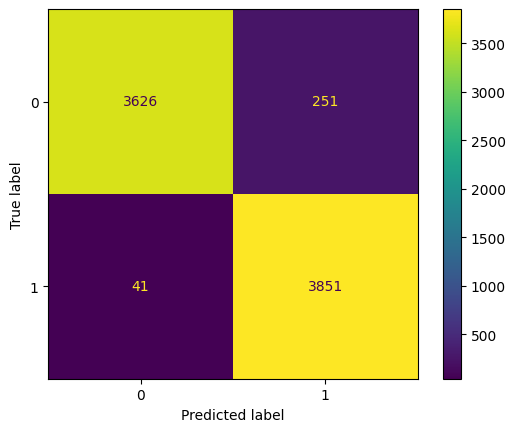

              precision    recall  f1-score   support

           0       0.99      0.94      0.96      3877
           1       0.94      0.99      0.96      3892

    accuracy                           0.96      7769
   macro avg       0.96      0.96      0.96      7769
weighted avg       0.96      0.96      0.96      7769



In [1405]:
print_confusion_matrix(y_train, y_train_pred_svm, svm)

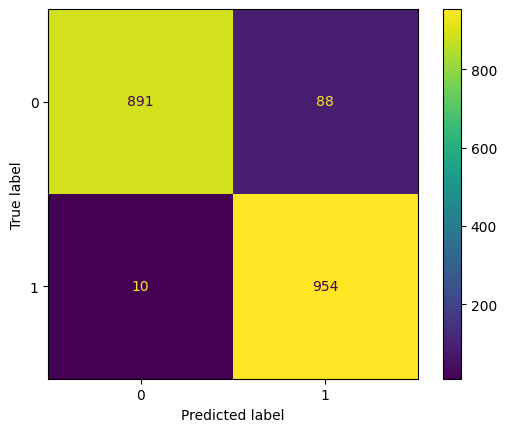

              precision    recall  f1-score   support

           0       0.99      0.91      0.95       979
           1       0.92      0.99      0.95       964

    accuracy                           0.95      1943
   macro avg       0.95      0.95      0.95      1943
weighted avg       0.95      0.95      0.95      1943



In [1406]:
print_confusion_matrix(y_test, y_test_pred_svm, svm)

### 8.3.1 - Model Saving

In [1407]:
save_model('svm', svm)

## 8.4 - Random Forest

In [1408]:
y_train_pred_rf = rf.predict(X_train_final)
y_test_pred_rf = rf.predict(X_test_final)

In [1409]:
print_accuracy_score(y_train, y_train_pred_rf)
print_accuracy_score(y_test, y_test_pred_rf)

Accuracy Score 1.0
Accuracy Score 0.9891919711785898


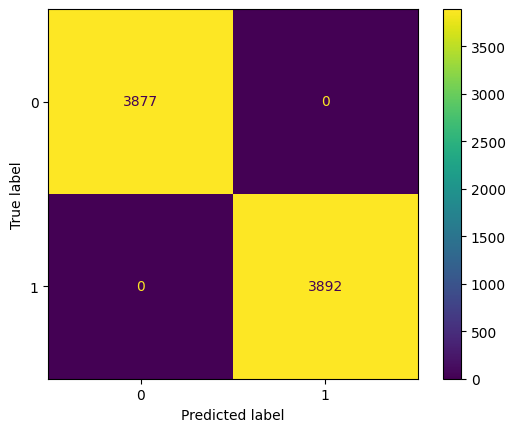

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3877
           1       1.00      1.00      1.00      3892

    accuracy                           1.00      7769
   macro avg       1.00      1.00      1.00      7769
weighted avg       1.00      1.00      1.00      7769



In [1410]:
print_confusion_matrix(y_train, y_train_pred_rf, rf)

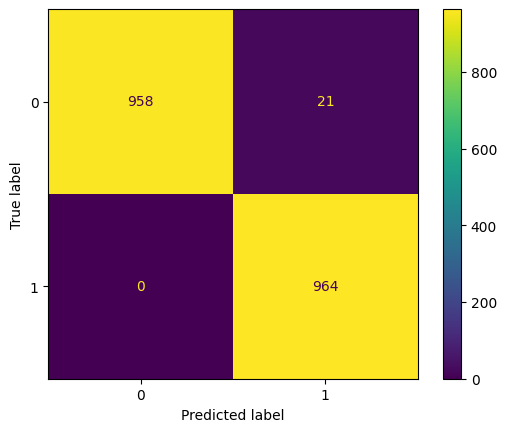

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       979
           1       0.98      1.00      0.99       964

    accuracy                           0.99      1943
   macro avg       0.99      0.99      0.99      1943
weighted avg       0.99      0.99      0.99      1943



In [1411]:
print_confusion_matrix(y_test, y_test_pred_rf, rf)

### 8.4.1 - Model Saving

In [1412]:
save_model('rf', rf)

## 8.5 - XGBoost

In [1413]:
y_train_pred_xgb = xgb.predict(X_train_final)
y_test_pred_xgb = xgb.predict(X_test_final)

In [1414]:
print_accuracy_score(y_train, y_train_pred_xgb)
print_accuracy_score(y_test, y_test_pred_xgb)

Accuracy Score 0.9925344317157936
Accuracy Score 0.9701492537313433


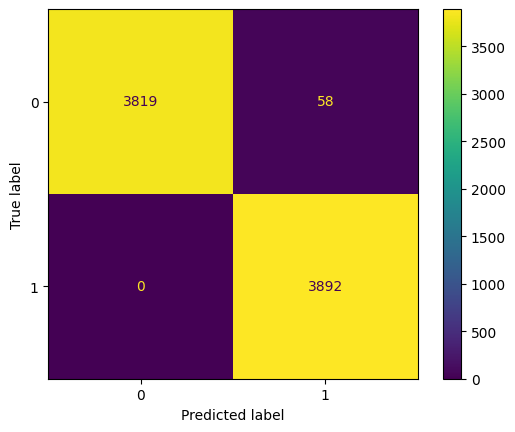

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      3877
           1       0.99      1.00      0.99      3892

    accuracy                           0.99      7769
   macro avg       0.99      0.99      0.99      7769
weighted avg       0.99      0.99      0.99      7769



In [1415]:
print_confusion_matrix(y_train, y_train_pred_xgb, xgb)

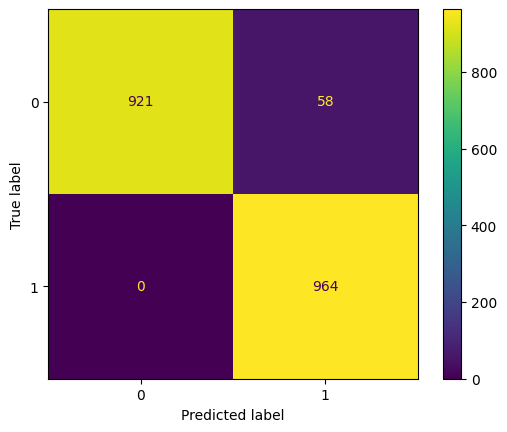

              precision    recall  f1-score   support

           0       1.00      0.94      0.97       979
           1       0.94      1.00      0.97       964

    accuracy                           0.97      1943
   macro avg       0.97      0.97      0.97      1943
weighted avg       0.97      0.97      0.97      1943



In [1416]:
print_confusion_matrix(y_test, y_test_pred_xgb, xgb)

### 8.5.1 - Model Saving

In [1417]:
save_model('xgb', xgb)

# 9 - Model Inference

In [1418]:
def load_model(folder_name):
    global model, scaler, ord_enc, ohc_enc, num_columns, ord_columns, ohc_columns
    
    with open('model/{0}/v1/model.pkl'.format(folder_name), 'rb') as file_1:
        model = joblib.load(file_1)

    with open('model/{0}/v1/scaler.pkl'.format(folder_name), 'rb') as file_2:
        scaler = joblib.load(file_2)

    with open('model/{0}/v1/ord_enc.pkl'.format(folder_name), 'rb') as file_3:
        ord_enc = joblib.load(file_3)

    with open('model/{0}/v1/ohc_enc.pkl'.format(folder_name), 'rb') as file_4:
        ohc_enc = joblib.load(file_4)

    with open('model/{0}/v1/num_columns.txt'.format(folder_name), 'r') as file_5:
        num_columns = json.load(file_5)

    with open('model/{0}/v1/ord_columns.txt'.format(folder_name), 'r') as file_6:
        ord_columns = json.load(file_6)

    with open('model/{0}/v1/ohc_columns.txt'.format(folder_name), 'r') as file_7:
        ohc_columns = json.load(file_7)

## 9.2 - KNN

### 9.2.1 - Load Model

In [1419]:
load_model('knn')

### 9.2.2 - Split dataset to numerical and categorical columns

In [1420]:
X_inf_num = data_inf[num_columns]
X_inf_ord = data_inf[ord_columns]
X_inf_ohc = data_inf[ohc_columns]

### 9.2.3 - Handling missing values

In [1421]:
X_inf_num.isnull().sum()

age                  0
avg_glucose_level    0
dtype: int64

In [1422]:
X_inf_ord.isnull().sum()

hypertension     0
heart_disease    0
ever_married     0
dtype: int64

In [1423]:
X_inf_ohc.isnull().sum()

work_type         0
Residence_type    0
smoking_status    0
dtype: int64

### 9.2.4 - Feature Engineering

In [1424]:
X_inf_num_scaled = scaler.transform(X_inf_num)
X_inf_ord_encoded = ord_enc.transform(X_inf_ord)
X_inf_ohc_encoded = ohc_enc.transform(X_inf_ohc).toarray()

### 9.2.5 - Concate numerical and categorical columns

In [1425]:
X_inf_final = np.concatenate([X_inf_num_scaled, X_inf_ord_encoded, X_inf_ohc_encoded], axis=1)

### 9.2.6 - Model Evaluation

In [1426]:
y_inf_pred_knn = model.predict(X_inf_final)

In [1427]:
print_accuracy_score(data_inf['stroke'], y_inf_pred_knn)

Accuracy Score 0.8


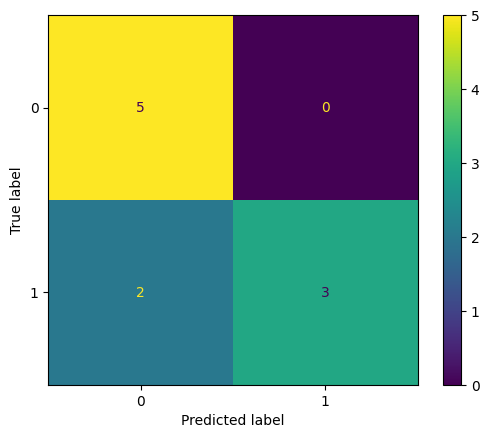

              precision    recall  f1-score   support

           0       0.71      1.00      0.83         5
           1       1.00      0.60      0.75         5

    accuracy                           0.80        10
   macro avg       0.86      0.80      0.79        10
weighted avg       0.86      0.80      0.79        10



In [1428]:
print_confusion_matrix(data_inf['stroke'], y_inf_pred_knn, model)

## 9.3 - SVM

### 9.3.1 - Load Model

In [1429]:
load_model('svm')

### 9.3.2 - Split dataset to numerical and categorical columns

In [1430]:
X_inf_num = data_inf[num_columns]
X_inf_ord = data_inf[ord_columns]
X_inf_ohc = data_inf[ohc_columns]

### 9.3.3 - Handling missing values

In [1431]:
X_inf_num.isnull().sum()

age                  0
avg_glucose_level    0
dtype: int64

In [1432]:
X_inf_ord.isnull().sum()

hypertension     0
heart_disease    0
ever_married     0
dtype: int64

In [1433]:
X_inf_ohc.isnull().sum()

work_type         0
Residence_type    0
smoking_status    0
dtype: int64

### 9.3.4 - Feature Engineering

In [1434]:
X_inf_num_scaled = scaler.transform(X_inf_num)
X_inf_ord_encoded = ord_enc.transform(X_inf_ord)
X_inf_ohc_encoded = ohc_enc.transform(X_inf_ohc).toarray()

### 9.3.5 - Concate numerical and categorical columns

In [1435]:
X_inf_final = np.concatenate([X_inf_num_scaled, X_inf_ord_encoded, X_inf_ohc_encoded], axis=1)

### 9.3.6 - Model Evaluation

In [1436]:
y_inf_pred_svm = model.predict(X_inf_final)

In [1437]:
print_accuracy_score(data_inf['stroke'], y_inf_pred_svm)

Accuracy Score 0.5


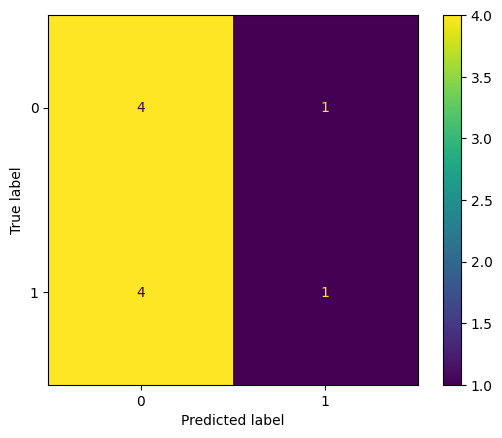

              precision    recall  f1-score   support

           0       0.50      0.80      0.62         5
           1       0.50      0.20      0.29         5

    accuracy                           0.50        10
   macro avg       0.50      0.50      0.45        10
weighted avg       0.50      0.50      0.45        10



In [1438]:
print_confusion_matrix(data_inf['stroke'], y_inf_pred_svm, model)

## 9.4 - Random Forest

### 9.4.1 - Load Model

In [1439]:
load_model('rf')

### 9.4.2 - Split dataset to numerical and categorical columns

In [1440]:
X_inf_num = data_inf[num_columns]
X_inf_ord = data_inf[ord_columns]
X_inf_ohc = data_inf[ohc_columns]

### 9.3.3 - Handling missing values

In [1441]:
X_inf_num.isnull().sum()

age                  0
avg_glucose_level    0
dtype: int64

In [1442]:
X_inf_ord.isnull().sum()

hypertension     0
heart_disease    0
ever_married     0
dtype: int64

In [1443]:
X_inf_ohc.isnull().sum()

work_type         0
Residence_type    0
smoking_status    0
dtype: int64

### 9.3.4 - Feature Engineering

In [1444]:
X_inf_num_scaled = scaler.transform(X_inf_num)
X_inf_ord_encoded = ord_enc.transform(X_inf_ord)
X_inf_ohc_encoded = ohc_enc.transform(X_inf_ohc).toarray()

### 9.3.5 - Concate numerical and categorical columns

In [1445]:
X_inf_final = np.concatenate([X_inf_num_scaled, X_inf_ord_encoded, X_inf_ohc_encoded], axis=1)

### 9.3.6 - Model Evaluation

In [1446]:
y_inf_pred_rf = model.predict(X_inf_final)

In [1447]:
print_accuracy_score(data_inf['stroke'], y_inf_pred_rf)

Accuracy Score 0.5


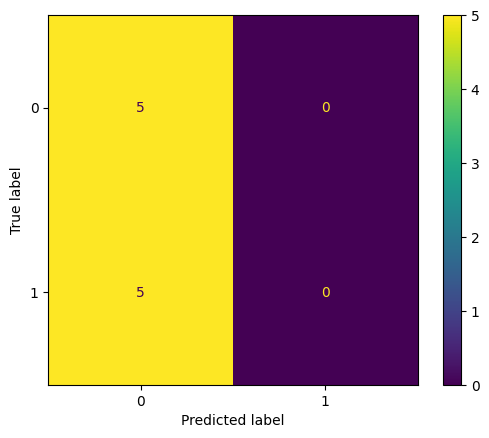

              precision    recall  f1-score   support

           0       0.50      1.00      0.67         5
           1       0.00      0.00      0.00         5

    accuracy                           0.50        10
   macro avg       0.25      0.50      0.33        10
weighted avg       0.25      0.50      0.33        10



In [1448]:
print_confusion_matrix(data_inf['stroke'], y_inf_pred_rf, model)

## 9.5 - XGBoost

### 9.5.1 - Load Model

In [1449]:
load_model('xgb')

### 9.5.2 - Split dataset to numerical and categorical columns

In [1450]:
X_inf_num = data_inf[num_columns]
X_inf_ord = data_inf[ord_columns]
X_inf_ohc = data_inf[ohc_columns]

### 9.5.3 - Handling missing values

In [1451]:
X_inf_num.isnull().sum()

age                  0
avg_glucose_level    0
dtype: int64

In [1452]:
X_inf_ord.isnull().sum()

hypertension     0
heart_disease    0
ever_married     0
dtype: int64

In [1453]:
X_inf_ohc.isnull().sum()

work_type         0
Residence_type    0
smoking_status    0
dtype: int64

### 9.5.4 - Feature Engineering

In [1454]:
X_inf_num_scaled = scaler.transform(X_inf_num)
X_inf_ord_encoded = ord_enc.transform(X_inf_ord)
X_inf_ohc_encoded = ohc_enc.transform(X_inf_ohc).toarray()

### 9.5.5 - Concate numerical and categorical columns

In [1455]:
X_inf_final = np.concatenate([X_inf_num_scaled, X_inf_ord_encoded, X_inf_ohc_encoded], axis=1)

### 9.5.6 - Model Evaluation

In [1456]:
y_inf_pred_xgb = model.predict(X_inf_final)

In [1457]:
print_accuracy_score(data_inf['stroke'], y_inf_pred_xgb)

Accuracy Score 0.7


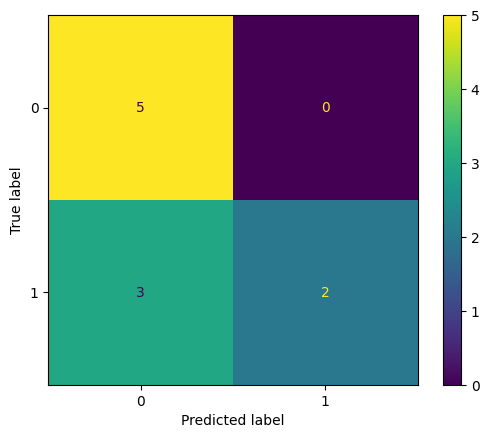

              precision    recall  f1-score   support

           0       0.62      1.00      0.77         5
           1       1.00      0.40      0.57         5

    accuracy                           0.70        10
   macro avg       0.81      0.70      0.67        10
weighted avg       0.81      0.70      0.67        10



In [1458]:
print_confusion_matrix(data_inf['stroke'], y_inf_pred_xgb, model)